![dims.jpg](dims.jpg)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30
        
<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>
        
<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from collections import Counter, defaultdict
import math
from subprocess import check_output
import os
import gc
import re
import nltk
nltk.download('stopwords')
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook

# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

import time
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import datetime as dt

# Algorithms 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection

# metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/passionateguy_bharat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2> 3.1 Reading data and basic stats </h2>

In [2]:
# https://drive.google.com/drive/folders/1OWZoiQDvAvgOa-IUnEQ-6QKSEp_pw1XO

df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.
    
<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(similar) and non-duplicate(non similar) questions

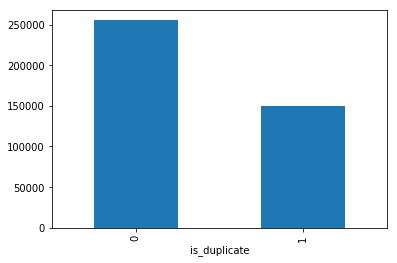

In [7]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [8]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



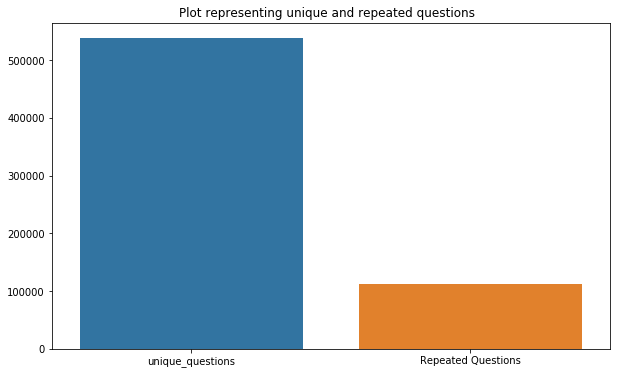

In [10]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



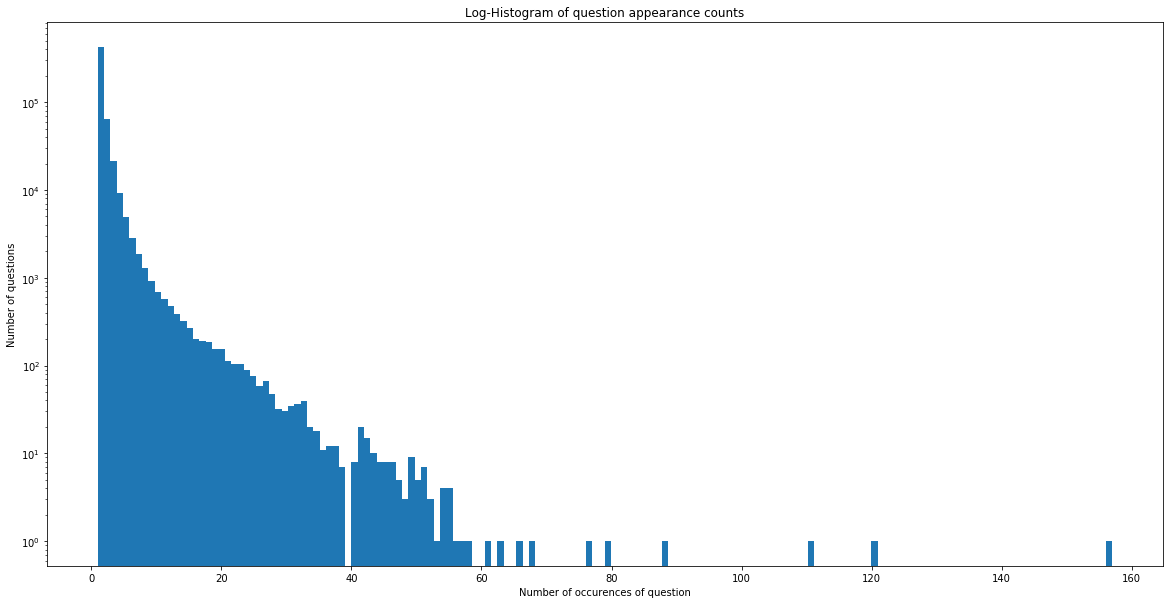

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [14]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
# Train

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train_new.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

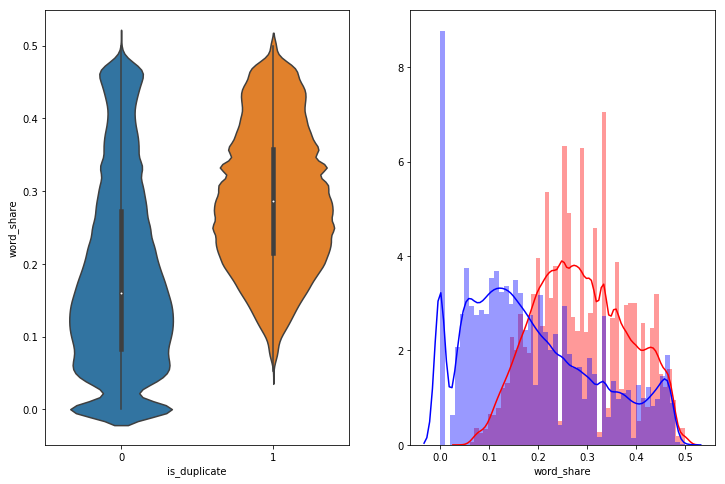

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1) # row, no of plots, 1st in row
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2) # row, no of plots, 2nd in row
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

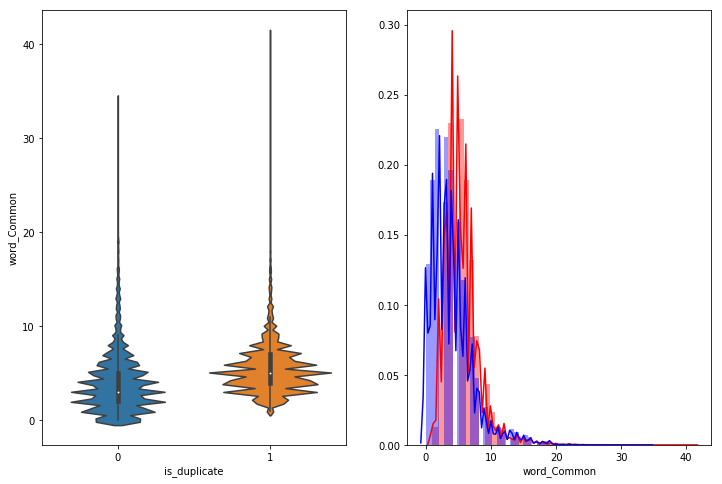

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1) # row, no of plots, 1st in row
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2) # row, no of plots, 2nd in row
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords (I am skipping)
    - Expanding contractions etc.

In [2]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

- Function to Compute and get the features: With 2 parameters of Question 1 and Question 2
    
<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
# I have skipped using df["csc_min"], df["csc_max"]

stopwords = set(STOPWORDS)

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stopwords.words('english')])
    q2_words = set([word for word in q2_tokens if word not in stopwords.words('english')])
    
    # I have skipped using this stopwords step
    '''
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stopwords.words('english')])
    q2_stops = set([word for word in q2_tokens if word in stopwords.words('english')])
    '''
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # I have skipped using this stopwords step
    '''
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    '''
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    
    # I have skipped using this stopwords step
    '''
     token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    '''
    token_features[2] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[3] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[4] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[5] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[6] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[7] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    
    # I have skipped using this stopwords step
    '''
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    '''
    
    df["ctc_min"]       = list(map(lambda x: x[2], token_features))
    df["ctc_max"]       = list(map(lambda x: x[3], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[4], token_features))
    df["first_word_eq"] = list(map(lambda x: x[5], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[6], token_features))
    df["mean_len"]      = list(map(lambda x: x[7], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

In [2]:
"""
if os.path.isfile('nlp_features_train_old.csv'):
    df = pd.read_csv("nlp_features_train_old.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)
"""
# As I am skipping stop words, hence using part of the code only

if not os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
else:
    df = pd.read_csv("nlp_features_train.csv")
    
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [51]:
df.shape

(404290, 19)

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [4]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [53]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()

# reading the text files and removing the Stop Words:

"""
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))
"""

'\nstopwords = set(STOPWORDS)\nstopwords.add("said")\nstopwords.add("br")\nstopwords.add(" ")\nstopwords.remove("not")\n\nstopwords.remove("no")\n#stopwords.remove("good")\n#stopwords.remove("love")\nstopwords.remove("like")\n#stopwords.remove("best")\n#stopwords.remove("!")\nprint ("Total number of words in duplicate pair questions :",len(textp_w))\nprint ("Total number of words in non duplicate pair questions :",len(textn_w))\n'

__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


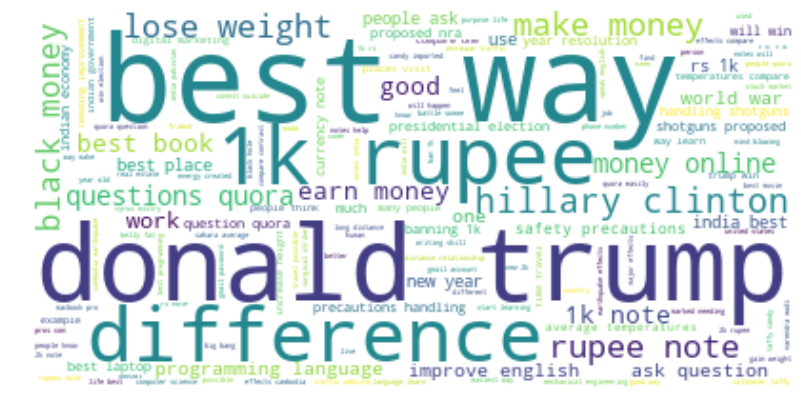

In [54]:
# we use this for stop words 
# wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)

wc = WordCloud(background_color="white", max_words=len(textp_w))
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


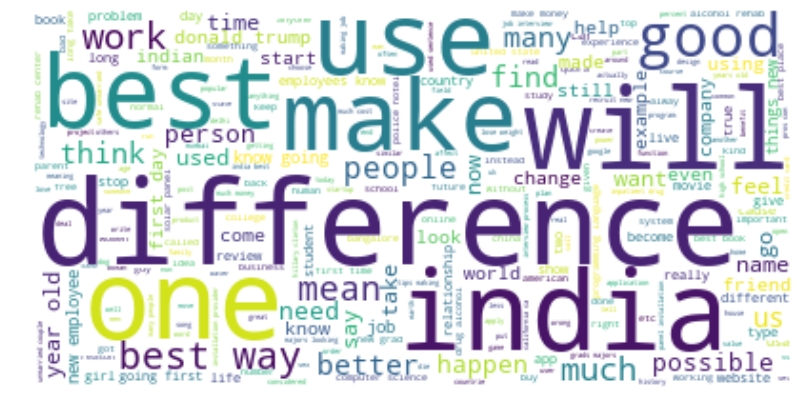

In [55]:
# we use this for stop words 
# wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)

wc = WordCloud(background_color="white", max_words=len(textn_w))
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'token_sort_ratio'] </h4>

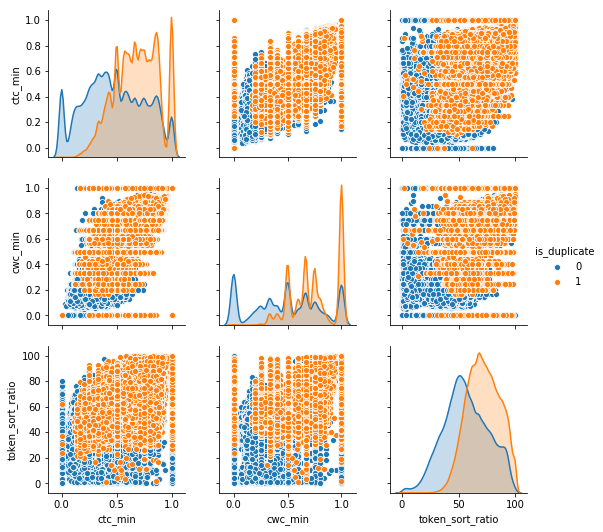

In [56]:
# we dont use 'csc_min'

n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'token_sort_ratio'])
plt.show()

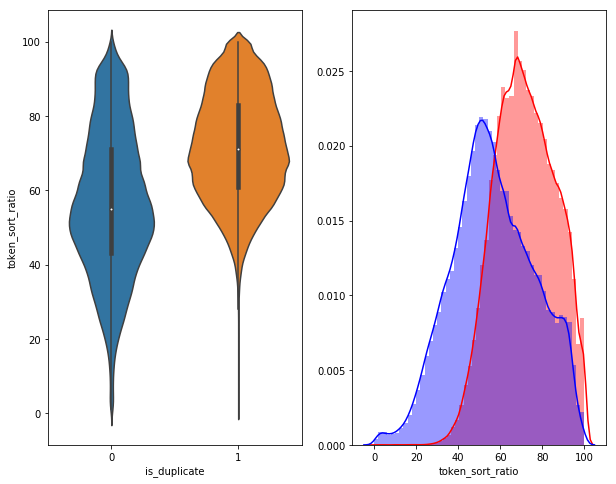

In [57]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

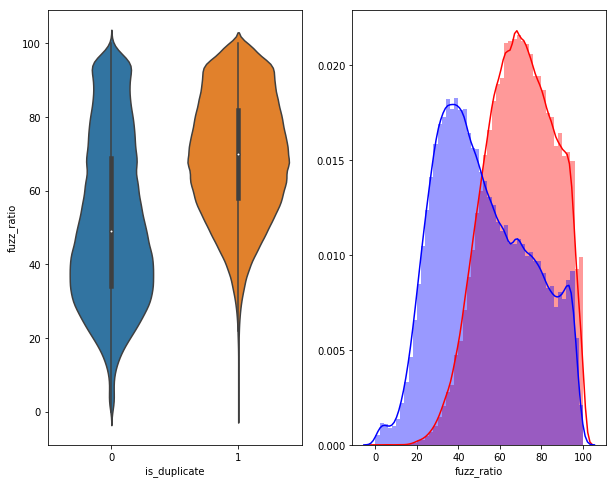

In [58]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [3]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

# Considering all 300k datapoints.
dfp_subsampled = df[:300000]

# skipping  'csc_min', 'csc_max' 
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [4]:
start = datetime.now()

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5).fit_transform(X)

print('Time to complete: ', datetime.now() - start)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300000 samples in 77.293s...
[t-SNE] Computed neighbors for 300000 samples in 228.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 300000
[t-SNE] Computed conditional probabilities for sample 2000 / 300000
[t-SNE] Computed conditional probabilities for sample 3000 / 300000
[t-SNE] Computed conditional probabilities for sample 4000 / 300000
[t-SNE] Computed conditional probabilities for sample 5000 / 300000
[t-SNE] Computed conditional probabilities for sample 6000 / 300000
[t-SNE] Computed conditional probabilities for sample 7000 / 300000
[t-SNE] Computed conditional probabilities for sample 8000 / 300000
[t-SNE] Computed conditional probabilities for sample 9000 / 300000
[t-SNE] Computed conditional probabilities for sample 10000 / 300000
[t-SNE] Computed conditional probabilities for sample 11000 / 300000
[t-SNE] Computed conditional probabilities for sample 12000 / 300000
[t-SNE] Computed conditional prob

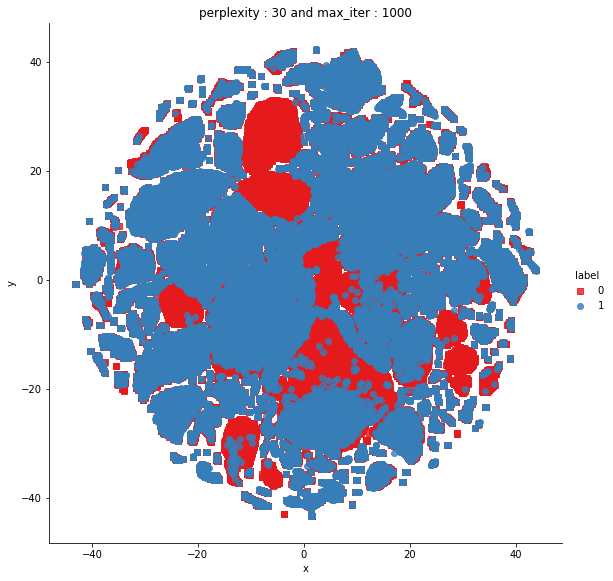

In [5]:
df1 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df1, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

# Splitting the data

In [4]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

In [6]:
# considering 1L datapoints for our case study
df1 =  df[:100000]

In [7]:
# Creating y label
y_true = df1['is_duplicate']

# dropping y-label from data thereby remaining data considered as x-label
df1.drop(['is_duplicate'],axis=1, inplace= True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df1, y_true, stratify=y_true, test_size=0.3)

In [6]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 5)
Number of data points in test data : (30000, 5)


In [7]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


# Part - I

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

In [6]:
# Train data

X_train['freq_qid1']  = X_train.groupby('qid1')['qid1'].transform('count') 
X_train['freq_qid2']  = X_train.groupby('qid2')['qid2'].transform('count')
X_train['q1len']      = X_train['question1'].str.len() 
X_train['q2len']      = X_train['question2'].str.len()
X_train['q1_n_words'] = X_train['question1'].apply(lambda row: len(row.split(" ")))
X_train['q2_n_words'] = X_train['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
X_train['word_Common'] = X_train.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
X_train['word_Total'] = X_train.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
X_train['word_share'] = X_train.apply(normalized_word_share, axis=1)

X_train['freq_q1+q2'] = X_train['freq_qid1'] + X_train['freq_qid2']
X_train['freq_q1-q2'] = abs(X_train['freq_qid1'] - X_train['freq_qid2'])


In [7]:
# Test data

X_test['freq_qid1']  = X_test.groupby('qid1')['qid1'].transform('count') 
X_test['freq_qid2']  = X_test.groupby('qid2')['qid2'].transform('count')
X_test['q1len']      = X_test['question1'].str.len() 
X_test['q2len']      = X_test['question2'].str.len()
X_test['q1_n_words'] = X_test['question1'].apply(lambda row: len(row.split(" ")))
X_test['q2_n_words'] = X_test['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
X_test['word_Common'] = X_test.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
X_test['word_Total'] = X_test.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
X_test['word_share'] = X_test.apply(normalized_word_share, axis=1)

X_test['freq_q1+q2'] = X_test['freq_qid1'] + X_test['freq_qid2']
X_test['freq_q1-q2'] = abs(X_test['freq_qid1'] - X_test['freq_qid2'])


### Tf-Idf

In [9]:
# Tfidf Vectorizer for linear models ()
# merging together under one column
X_train['questions'] = X_train['question1'].map(str) + X_train['question2'].map(str)
X_test['questions'] = X_test['question1'].map(str) + X_test['question2'].map(str)

# Train
tfidf = TfidfVectorizer(min_df = 10, ngram_range = (1,2))
tfidf_tr = tfidf.fit_transform(X_train['questions'])         # fit and transform

# Test
tfidf_ts = tfidf.transform(X_test['questions'])             # transform

In [10]:
print("Number of data points in Tfidf train data :",tfidf_tr.shape)
print("Number of data points in Tfidf test data :",tfidf_ts.shape)

Number of data points in Tfidf train data : (70000, 21006)
Number of data points in Tfidf test data : (30000, 21006)


In [11]:
# merge texts

# Train
questions_train = list(X_train['question1']) + list(X_train['question2'])

# Test
questions_test = list(X_test['question1']) + list(X_test['question2'])

### Tf-Idf W2V

In [12]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [13]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
# ! python3 -m spacy download en_core_web_sm --user (doesnt work) hence we use below code
# https://github.com/explosion/spaCy/issues/4577

'''
! pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz 
--user
'''

# https://stackoverflow.com/a/50487792/10219869

import en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [14]:
# Train question1

vecs1_train = []
# https://github.com/noamraph/tqdm
# tqdm_notebook is used to print the progress bar
for qu1 in tqdm_notebook(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch idf score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_train.append(mean_vec1)
X_train['q1_feats_m_train'] = vecs1_train

In [15]:
len(X_train['q1_feats_m_train'][0])

300

In [16]:
# Test question1

vecs1_test = []
# https://github.com/noamraph/tqdm
# tqdm_notebook is used to print the progress bar
for qu1 in tqdm_notebook(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1_test.append(mean_vec1)
X_test['q1_feats_m_test'] = vecs1_test

In [17]:
# Train question2

vecs2_train = []
for qu2 in tqdm_notebook(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    # 96 is the number of dimensions of vectors
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2_train.append(mean_vec2)
X_train['q2_feats_m_train'] = vecs2_train

In [18]:
# Test question2

vecs2_test = []
for qu2 in tqdm_notebook(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    # 96 is the number of dimensions of vectors
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2_test.append(mean_vec2)
X_test['q2_feats_m_test'] = vecs2_test

# Part II

In [19]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

# Train

# I have skipped using df["csc_min"], df["csc_max"], ["cwc_min"], ["cwc_max"]

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # I have skipped using this stopwords step
    
    '''
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stopwords.words('english')])
    q2_words = set([word for word in q2_tokens if word not in stopwords.words('english')])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stopwords.words('english')])
    q2_stops = set([word for word in q2_tokens if word in stopwords.words('english')])

    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # I have skipped using this stopwords step
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    '''
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    '''
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    
     token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    '''
    token_features[0] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[1] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[2] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[3] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[4] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[5] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

def extract_features(X_train):
    # preprocessing each question
    X_train["question1"] = X_train["question1"].fillna("").apply(preprocess)
    X_train["question2"] = X_train["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = X_train.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    # I have skipped using this stopwords step
    ''' 
    X_train["cwc_min"]       = list(map(lambda x: x[0], token_features))
    X_train["cwc_max"]       = list(map(lambda x: x[1], token_features))
    
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    '''

    X_train["ctc_min"]       = list(map(lambda x: x[0], token_features))
    X_train["ctc_max"]       = list(map(lambda x: x[1], token_features))
    X_train["last_word_eq"]  = list(map(lambda x: x[2], token_features))
    X_train["first_word_eq"] = list(map(lambda x: x[3], token_features))
    X_train["abs_len_diff"]  = list(map(lambda x: x[4], token_features))
    X_train["mean_len"]      = list(map(lambda x: x[5], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    
    print("fuzzy features..")

    X_train["token_set_ratio"]       = X_train.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    
    """
    The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and then joining
    them back into a string We then compare the transformed strings with a simple ratio().
    """
    
    X_train["token_sort_ratio"]      = X_train.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    X_train["fuzz_ratio"]            = X_train.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    X_train["fuzz_partial_ratio"]    = X_train.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    X_train["longest_substr_ratio"]  = X_train.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), 
                                                     axis=1)
    
    return X_train

In [21]:
# Train
start = datetime.now()
X_train_fuzz = extract_features(X_train)
print('Time taken to complete: ', datetime.now()-start)

token features...
fuzzy features..
Time taken to complete:  0:06:08.826427


In [22]:
# Test

# I have skipped using df["csc_min"], df["csc_max"]

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # I have skipped using this stopwords step
    
    '''
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stopwords.words('english')])
    q2_words = set([word for word in q2_tokens if word not in stopwords.words('english')])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stopwords.words('english')])
    q2_stops = set([word for word in q2_tokens if word in stopwords.words('english')])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
        
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    '''
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    '''
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    
     token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    '''
    
    token_features[0] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[1] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[2] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[3] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[4] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[5] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

def extract_features(X_test):
    # preprocessing each question
    X_test["question1"] = X_test["question1"].fillna("").apply(preprocess)
    X_test["question2"] = X_test["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = X_test.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    # I have skipped using this stopwords step
    '''
    X_test["cwc_min"]       = list(map(lambda x: x[0], token_features))
    X_test["cwc_max"]       = list(map(lambda x: x[1], token_features))
    
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    '''
    
    X_test["ctc_min"]       = list(map(lambda x: x[0], token_features))
    X_test["ctc_max"]       = list(map(lambda x: x[1], token_features))
    X_test["last_word_eq"]  = list(map(lambda x: x[2], token_features))
    X_test["first_word_eq"] = list(map(lambda x: x[3], token_features))
    X_test["abs_len_diff"]  = list(map(lambda x: x[4], token_features))
    X_test["mean_len"]      = list(map(lambda x: x[5], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    
    print("fuzzy features..")

    X_test["token_set_ratio"]       = X_test.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    
    """
    The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and then joining
    them back into a string We then compare the transformed strings with a simple ratio().
    """
    
    X_test["token_sort_ratio"]      = X_test.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    X_test["fuzz_ratio"]            = X_test.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    X_test["fuzz_partial_ratio"]    = X_test.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    X_test["longest_substr_ratio"]  = X_test.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), 
                                                   axis=1)
    
    return X_test

In [23]:
# Test
start=datetime.now()
X_test_fuzz = extract_features(X_test)
print('Time taken to complete: ', datetime.now()-start)

token features...
fuzzy features..
Time taken to complete:  0:02:38.153609


In [24]:
print("Number of data points in train data :", X_train_fuzz.shape)
print("Number of data points in test data :", X_test_fuzz.shape)

Number of data points in train data : (70000, 30)
Number of data points in test data : (30000, 30)


In [25]:
X_train_fuzz.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
19318,19318,36506,36507,could anyone write a c program to display a bi...,what is the difference between a avl tree and ...,1,1,96,67,18,...,0.277776,0.0,0.0,5.0,15.5,58,52,34,46,0.323529
83141,83141,140825,140826,in today own society what is considered dating,what salary range do you need to make to be co...,1,1,46,78,7,...,0.266665,0.0,0.0,7.0,11.5,72,60,34,50,0.244898


In [28]:
# converting the w2v (300 vectors) to dataframe
# Train

X_train_q1 = pd.DataFrame(X_train['q1_feats_m_train'].values.tolist(), index= X_train.index, columns= ['0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x'])
X_train_q2 = pd.DataFrame(X_train['q2_feats_m_train'].values.tolist(), index= X_train.index, columns= ['0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y'])

In [29]:
# Test

X_test_q1 = pd.DataFrame(X_test['q1_feats_m_test'].values.tolist(), index= X_test.index, columns= ['0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x'])
X_test_q2 = pd.DataFrame(X_test['q2_feats_m_test'].values.tolist(), index= X_test.index, columns= ['0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y'])

In [30]:
# must be 300 features
print("Number of data points in train q1 data :",X_train_q1.shape)
print("Number of data points in train q2 data :",X_train_q2.shape)
print("Number of data points in test q1 data :",X_test_q1.shape)
print("Number of data points in test q2 data :",X_test_q2.shape)

Number of data points in train q1 data : (70000, 300)
Number of data points in train q2 data : (70000, 300)
Number of data points in test q1 data : (30000, 300)
Number of data points in test q2 data : (30000, 300)


In [31]:
# https://stackoverflow.com/a/43580536/10219869

# Train
X_train_fuzz.drop(['id', 'q1_feats_m_train', 'q2_feats_m_train', 'question1', 'question2', 'questions', 'qid1', 'qid2'], axis=1, inplace=True)

# Test
X_test_fuzz.drop(['id', 'q1_feats_m_test', 'q2_feats_m_test', 'question1', 'question2', 'questions', 'qid1', 'qid2'], axis=1, inplace=True)

In [32]:
pd.set_option('display.max_columns', 500)
# After removal of w2v
X_train_fuzz.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
19318,19318,1,1,96,67,18,13,5.0,29.0,0.172414,2,0,0.384612,0.277776,0.0,0.0,5.0,15.5,58,52,34,46,0.323529
83141,83141,1,1,46,78,7,15,3.0,21.0,0.142857,2,0,0.499994,0.266665,0.0,0.0,7.0,11.5,72,60,34,50,0.244898


In [33]:
X_train_fuzz.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

# Part III

### X_train_fuzz with 28 NLP features are common for the XGB dataframe and Linear dataframe

In [34]:
# Train XGB 
X_train_xgb = pd.concat([X_train_fuzz, X_train_q1, X_train_q2], axis=1)

# Test XGB 
X_test_xgb = pd.concat([X_test_fuzz, X_test_q1, X_test_q2], axis=1)


In [35]:
print("Number of data points in train data :",X_train_xgb.shape)
print("Number of data points in test data :",X_test_xgb.shape)

Number of data points in train data : (70000, 623)
Number of data points in test data : (30000, 623)


In [37]:
# Exporting to csv
X_train_xgb.to_csv('X_train_xgb_new300.csv')
X_test_xgb.to_csv('X_test_xgb_new300.csv')

In [55]:
X_train_xgb = pd.read_csv('X_train_xgb_new300.csv') 
X_test_xgb = pd.read_csv('X_test_xgb_new300.csv')

In [56]:
X_train_xgb.drop(['Unnamed: 0'], axis=1, inplace=True)
X_test_xgb.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
X_train_fuzz_linear = pd.read_csv('X_train_xgb_new300.csv')
X_train_fuzz_linear = X_train_fuzz_linear[['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words','q2_n_words', 'word_Common', 
                                           'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'ctc_min', 'ctc_max', 'last_word_eq', 
                                           'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 
                                           'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']]

In [30]:
# https://stackoverflow.com/a/51701528/10219869

from scipy.sparse import coo_matrix, hstack
(coo_matrix(tfidf_tr)).shape

(70000, 21006)

In [31]:
X_train_linear1 = hstack((X_train_fuzz_linear, (coo_matrix(tfidf_tr))))

In [32]:
X_test_fuzz = pd.read_csv('X_test_xgb_new300.csv')
X_test_fuzz = X_test_fuzz[['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words','q2_n_words', 'word_Common', 
                             'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'ctc_min', 'ctc_max', 'last_word_eq', 
                             'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 
                             'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']]

In [36]:
X_test_linear1 = hstack((X_test_fuzz, coo_matrix(tfidf_ts)))

In [37]:
print("Number of data points in train data :",X_train_linear1.shape)
print("Number of data points in test data :",X_test_linear1.shape)

Number of data points in train data : (70000, 21028)
Number of data points in test data : (30000, 21028)


<h1>4. Machine Learning Models </h1>

In [38]:
# Created my own function with slight changes

def confusionmatrix(test_y, predict_y):
    c_m = confusion_matrix(y_test, predict_y)
    
    precision = (c_m / c_m.sum(axis=0))
    recall = (c_m.T / c_m.sum(axis=0)).T
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(c_m, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(precision, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(recall, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8884684277744512


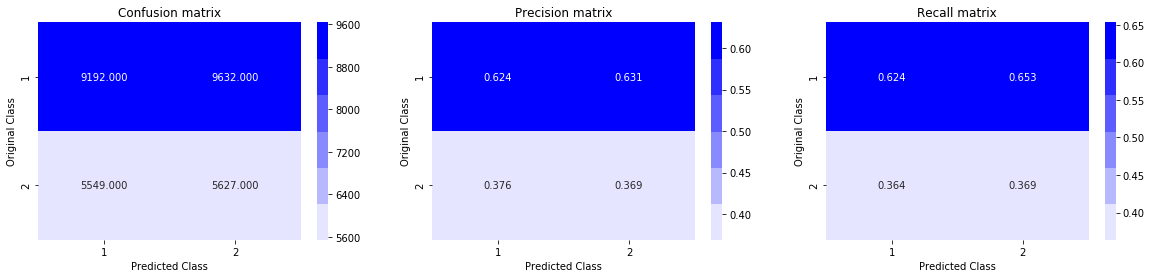

In [32]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

pred_y = np.argmax(predicted_y, axis=1)
confusionmatrix(y_true, pred_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

### Class Balanced

In [49]:
start = datetime.now()
alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_linear1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_linear1, y_train)
    predict_y = sig_clf.predict_proba(X_test_linear)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print('time taken: ', datetime.now()-start)

For values of alpha =  1e-07 The log loss is: 0.6465338571653076
For values of alpha =  1e-06 The log loss is: 0.5987604129245311
For values of alpha =  1e-05 The log loss is: 0.5863631702627327
For values of alpha =  0.0001 The log loss is: 0.6002078093086859
For values of alpha =  0.001 The log loss is: 0.6273421951901534
For values of alpha =  0.01 The log loss is: 0.6492226059548123
For values of alpha =  0.1 The log loss is: 0.6596394463178066
For values of alpha =  1 The log loss is: 0.6602836598503838
For values of alpha =  10 The log loss is: 0.6603253104808529
time taken:  0:09:12.829812


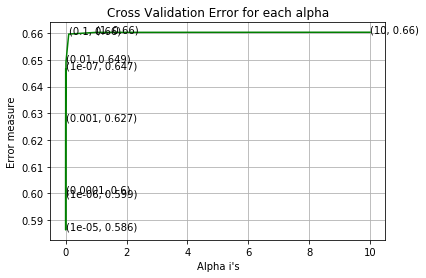

For values of best alpha =  1e-05 The train log loss is: 0.5840872241299851
For values of best alpha =  1e-05 The test log loss is: 0.5863631702627327
Total number of data points : 30000


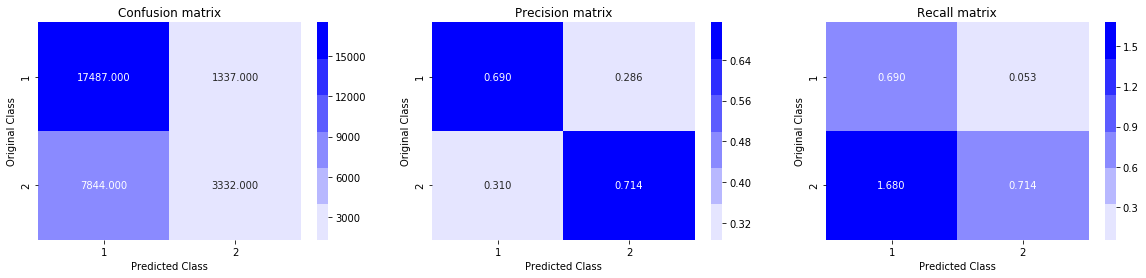

In [50]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, class_weight= 'balanced')
clf.fit(X_train_linear1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_linear1, y_train)

predict_y = sig_clf.predict_proba(X_train_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
confusionmatrix(y_test, predicted_y)

### Class Unbalanced

In [40]:
start = datetime.now()
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_linear1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_linear1, y_train)
    predict_y = sig_clf.predict_proba(X_test_linear)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print('time taken: ', datetime.now()-start)

For values of alpha =  1e-05 The log loss is: 0.585846300666967
For values of alpha =  0.0001 The log loss is: 0.6025522166121051
For values of alpha =  0.001 The log loss is: 0.6325275683808731
For values of alpha =  0.01 The log loss is: 0.653083913388061
For values of alpha =  0.1 The log loss is: 0.6597885530880846
For values of alpha =  1 The log loss is: 0.660263141010859
For values of alpha =  10 The log loss is: 0.6602819625141958
time taken:  0:06:56.491708


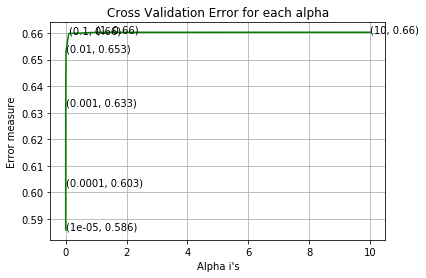

For values of best alpha =  1e-05 The train log loss is: 0.584288620485855
For values of best alpha =  1e-05 The test log loss is: 0.585846300666967
Total number of data points : 30000


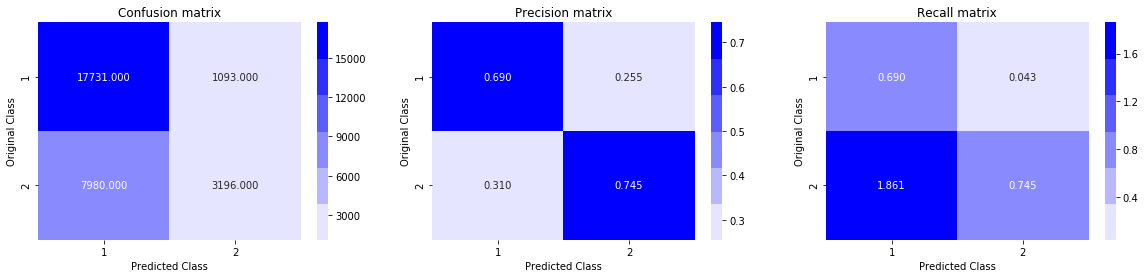

In [41]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_linear1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_linear1, y_train)

predict_y = sig_clf.predict_proba(X_train_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
confusionmatrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

### Class Balanced

In [51]:
alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_linear1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_linear1, y_train)
    predict_y = sig_clf.predict_proba(X_test_linear1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-07 The log loss is: 0.6602902109101162
For values of alpha =  1e-06 The log loss is: 0.5524478249145085
For values of alpha =  1e-05 The log loss is: 0.559597635154904
For values of alpha =  0.0001 The log loss is: 0.5919918545097376
For values of alpha =  0.001 The log loss is: 0.6342428168924167
For values of alpha =  0.01 The log loss is: 0.660290210209969
For values of alpha =  0.1 The log loss is: 0.660290210209969
For values of alpha =  1 The log loss is: 0.660290210209969
For values of alpha =  10 The log loss is: 0.660290210209969


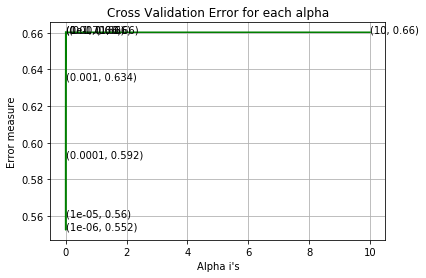

For values of best alpha =  1e-06 The train log loss is: 0.5481887889186696
For values of best alpha =  1e-06 The test log loss is: 0.5524478249145085
Total number of data points : 30000


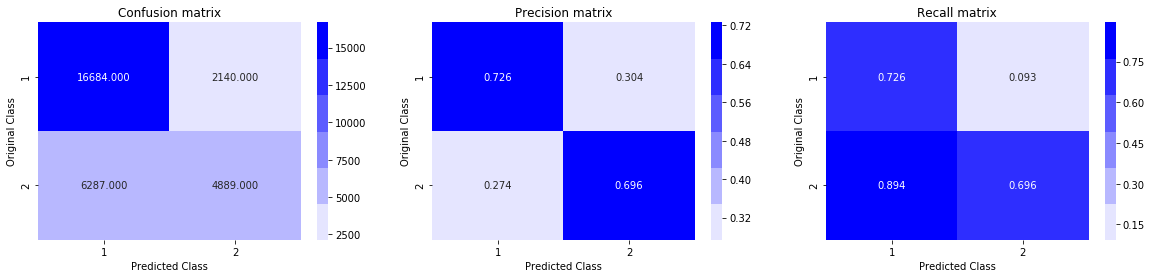

In [52]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(X_train_linear1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_linear1, y_train)

predict_y = sig_clf.predict_proba(X_train_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
confusionmatrix(y_test, predicted_y)

### Class Unbalanced

In [45]:
alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_linear1, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_linear1, y_train)
    predict_y = sig_clf.predict_proba(X_test_linear1)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-07 The log loss is: 0.6602902109101162
For values of alpha =  1e-06 The log loss is: 0.5584227358352738
For values of alpha =  1e-05 The log loss is: 0.5630698752317267
For values of alpha =  0.0001 The log loss is: 0.59723346864655
For values of alpha =  0.001 The log loss is: 0.6358338127455307
For values of alpha =  0.01 The log loss is: 0.6603045033269931
For values of alpha =  0.1 The log loss is: 0.6602858638229934
For values of alpha =  1 The log loss is: 0.6602615784104585
For values of alpha =  10 The log loss is: 0.6602800065227967


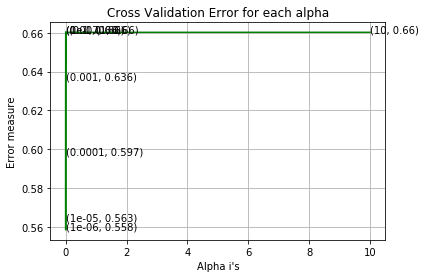

For values of best alpha =  1e-06 The train log loss is: 0.5545123661381038
For values of best alpha =  1e-06 The test log loss is: 0.5584227358352738
Total number of data points : 30000


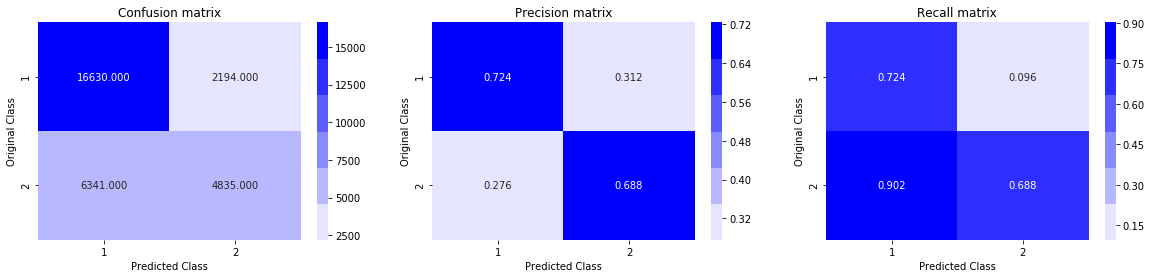

In [46]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_linear1, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_linear1, y_train)

predict_y = sig_clf.predict_proba(X_train_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_linear1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
confusionmatrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

### Class Balanced

In [41]:
count0=0
for i in y_train:
    if i == 0:
        count0 += 1
print(count0)

43922


In [42]:
count1=0
for i in y_train:
    if i == 1:
        count1 += 1
print(count1)

26078


In [43]:
# sum(negative instances) / sum(positive instances)
scale_pos_weight = count1 / count0
scale_pos_weight

0.5937343472519466

In [44]:
# https://xgboost.readthedocs.io/en/latest/parameter.html

start = datetime.now()
parameters = {'n_estimators'    : [500, 1000, 2000],
              'objective'       : ['binary:logistic', 'binary:hinge', 'reg:squarederror'],
              'eval_metric'     : ['logloss', 'error'],
              'max_depth'       : [4, 6, 8],
              'eta'             : [0.001, 0.02, 0.3],
              'gamma'           : [0, 0.1, 5, 10, 15],
              'min_child_weight': [3, 5, 7],
              'reg_alpha'       : [0.005, 0.01, 0],
              'reg_lambda'      : [0.005, 0.01, 1]}

rscv = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_jobs= -1, scale_pos_weight = scale_pos_weight),
                          param_distributions = parameters, n_jobs= -1, return_train_score=True, scoring = 'roc_auc')
rscv.fit(X_train_xgb, y_train)
print('Time taken to complete train linear data: ', datetime.now()-start)

Time taken to complete train linear data:  9:17:27.325887


In [45]:
print('Best parameters: \n',rscv.best_estimator_)
print()
print('ROC AUC Score: ',rscv.score(X_test_xgb, y_test))

Best parameters: 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='logloss', gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=7, missing=None,
              n_estimators=2000, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5937343472519466, seed=None,
              silent=None, subsample=1, verbosity=1)

ROC AUC Score:  0.9048428929197134


The train log loss is: 0.17649529552819543
The test log loss is: 0.4095087231363952
Total number of data points : 30000


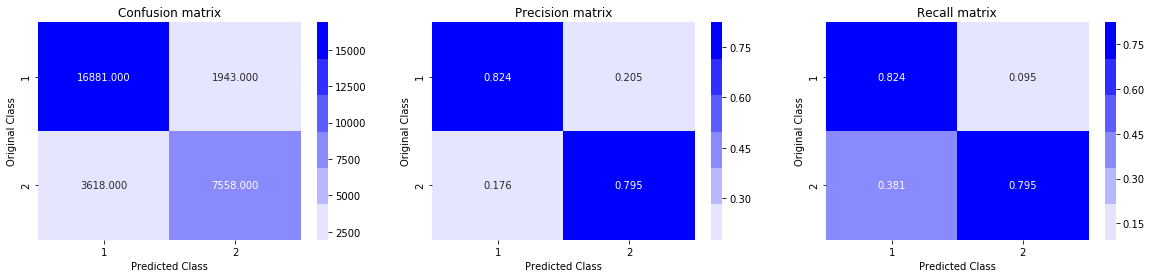

Time taken to complete train linear data:  2:14:24.851044


In [46]:
start = datetime.now()

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, 
                        eta=0.3, eval_metric='logloss', gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=6, 
                        min_child_weight=7, missing=None, n_estimators=2000, n_jobs=-1, nthread=None, random_state=0,
                        objective='binary:logistic', reg_alpha=0, reg_lambda=1, scale_pos_weight=0.5937343472519466, 
                        seed=None, silent=None, subsample=1, verbosity=1)

clf.fit(X_train_xgb, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_xgb, y_train)

predict_y = sig_clf.predict_proba(X_train_xgb)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_xgb)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))
confusionmatrix(y_test, predicted_y)

print('Time taken to complete train linear data: ', datetime.now()-start)

### class not balanced

In [12]:
# https://xgboost.readthedocs.io/en/latest/parameter.html

start= datetime.now()
parameters = {'n_estimators'    : [500, 1000, 2000],
              'objective'       : ['binary:logistic', 'binary:hinge', 'reg:squarederror'],
              'eval_metric'     : ['logloss', 'error'],
              'max_depth'       : [4, 6, 8],
              'eta'             : [0.001, 0.02, 0.3],
              'gamma'           : [0, 0.001, 0.1, 10, 15],
              'min_child_weight': [3, 5, 7],
              'reg_alpha'       : [0.005, 0.01, 0],
              'reg_lambda'      : [0.005, 0.01, 1]}

rscv_nb = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_jobs= -1,), param_distributions = parameters, cv=2, n_jobs= -1, 
                             return_train_score=True, scoring = 'roc_auc')

# nb = not balanced
rscv_nb.fit(X_train_xgb, y_train)

print('Time taken to complete train linear data: ', datetime.now()-start)

Time taken to complete train linear data:  4:08:27.061800


In [13]:
print('Best parameters: \n',rscv_nb.best_estimator_)
print()
print('ROC AUC Score: ',rscv_nb.score(X_test_xgb, y_test))

Best parameters: 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.001,
              eval_metric='logloss', gamma=0.001, learning_rate=0.1,
              max_delta_step=0, max_depth=8, min_child_weight=5, missing=None,
              n_estimators=500, n_jobs=-1, nthread=None,
              objective='binary:hinge', random_state=0, reg_alpha=0.01,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

ROC AUC Score:  0.49845646642477465


The train log loss is: 0.3311242344470857
The test log loss is: 0.4200542157574379
Total number of data points : 30000


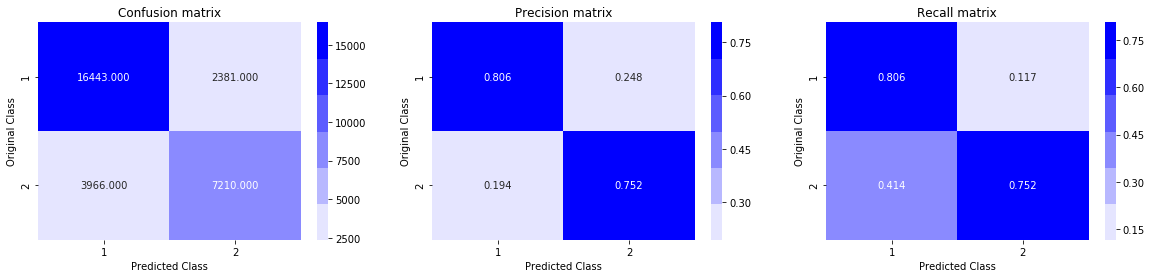

In [40]:

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, 
                        eta=0.02, eval_metric='logloss', gamma=15, learning_rate=0.1, max_delta_step=0, max_depth=8, 
                        min_child_weight=5, missing=None, n_estimators=2000, n_jobs=-1, nthread=None, random_state=0,
                        objective='binary:logistic', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                        subsample=1, verbosity=1)

clf.fit(X_train_xgb, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_xgb, y_train)

predict_y = sig_clf.predict_proba(X_train_xgb)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_xgb)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
confusionmatrix(y_test, predicted_y)

### Observations

* With Class not balanced we get less Precision and Recall than with Class balanced (Scale_pos_weight)

# Conclusions

In [62]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Rank", "Model", 'Type of Vector','Parameter', 'Class Weight', 'Train Log Loss', 'Test Log Loss']
x.add_row([1, "XGBC", 'Gamma = 0.1', 'Tf-idf W W2V', 'Balanced', '0.17', '0.41'])
x.add_row([2, "XGBC", 'Gamma = 15', 'Tf-idf W W2V', 'Unbalanced', '0.33', '0.42'])
x.add_row([3, "SGDC(Hinge Loss)", 'Alpha = 1e-6', 'Simple Tf-idf', 'Balanced', '0.548', '0.552'])
x.add_row([4, "SGDC(Hinge Loss)", 'Alpha = 1e-6', 'Simple Tf-idf', 'Unalanced', '0.554', '0.558'])
x.add_row([5, "SGDC(Log Loss)", 'Alpha = 1e-5', 'Simple Tf-idf', 'Balanced', '0.584', '0.586'])
x.add_row([6, "SGDC(Log Loss)", 'Alpha = 1e-5', 'Simple Tf-idf', 'Unalanced', '0.584', '0.586'])
x.add_row([7, 'Random Model', '-','-', '-', '-', '0.88'])

print(x)

+------+------------------+----------------+---------------+--------------+----------------+---------------+
| Rank |      Model       | Type of Vector |   Parameter   | Class Weight | Train Log Loss | Test Log Loss |
+------+------------------+----------------+---------------+--------------+----------------+---------------+
|  1   |       XGBC       |  Gamma = 0.1   |  Tf-idf W W2V |   Balanced   |      0.17      |      0.41     |
|  2   |       XGBC       |   Gamma = 15   |  Tf-idf W W2V |  Unbalanced  |      0.33      |      0.42     |
|  3   | SGDC(Hinge Loss) |  Alpha = 1e-6  | Simple Tf-idf |   Balanced   |     0.548      |     0.552     |
|  4   | SGDC(Hinge Loss) |  Alpha = 1e-6  | Simple Tf-idf |  Unalanced   |     0.554      |     0.558     |
|  5   |  SGDC(Log Loss)  |  Alpha = 1e-5  | Simple Tf-idf |   Balanced   |     0.584      |     0.586     |
|  6   |  SGDC(Log Loss)  |  Alpha = 1e-5  | Simple Tf-idf |  Unalanced   |     0.584      |     0.586     |
|  7   |   Random M